In [1]:
import sys
import math
import pandas as pd
import numpy as np
import causalimpact as ci
import json
import matplotlib.pyplot as plt
import warnings

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

from Utilities import reader_writer
from Utilities import query_engines

rw = reader_writer.Reader_Writer()

# SPM Group creator

**Context**
<br>
The POPs Team wants to run some tests with different partners to see which level of aggressiveness works best. In order to do this, they need to divide their sample data into two groups - a CONTROL group and a TREAT group.
<br>
<br>
To resolve the question of what is the best grouping, we use this script for each partner
<br>
<br>
A fake synthtetic control analysis is used to decide which is the best partners' grouping. After an imaginary TREATMENT we perform a synthetic control analysis to the CONTROL and TREAT group. The least difference between CONTROL and TREAT is the group that we consider to be the best predictor. In terms of p-value, this happens when the p-value is the highest value.
<br>
<br>
**Approach**
For synthetic control analysis I use the following convetions:
- 80% TREAT, 20% CONTROL
- I use 6 complete weeks of data, using 2 to evaluate changes

### Store universe definition

In [2]:
# METHOD 2 - We know the stores that have SPM activated
# We read the .csv from config_prod and we extract the information

# Params
country_code = 'GE'
group_name = 'CARR_GE'

# Read csv
d_stores = rw.csv_read_file('config_prod - config_prod (5).csv')
cond1 = d_stores['country_code']==country_code
cond2 = d_stores['group_name']==group_name
d_stores = d_stores[cond1&cond2]

d_stores = d_stores.rename(columns={'country_code':'order_descriptors.order_country_code'
                                    ,'store_address_id':'order_descriptors.store_address_id'
                                    ,'store_name':'order_descriptors.store_name'})

d_stores = d_stores[['order_descriptors.order_country_code','order_descriptors.store_name','order_descriptors.store_address_id']].reset_index(drop=True)
print('There are {} distinct store names'.format(d_stores['order_descriptors.store_name'].nunique()))
print('There are {} distinct store addresses'.format(d_stores['order_descriptors.store_address_id'].nunique()))
d_stores

There are 1 distinct store names
There are 29 distinct store addresses


,order_descriptors.order_country_code,order_descriptors.store_name,order_descriptors.store_address_id
0,GE,Carrefour,136826
1,GE,Carrefour,136828
2,GE,Carrefour,136829
3,GE,Carrefour,136830
4,GE,Carrefour,136831
5,GE,Carrefour,136832
6,GE,Carrefour,137063
7,GE,Carrefour,137064
8,GE,Carrefour,137065
9,GE,Carrefour,137066


In [3]:
# Enrich d_stores with Orders and PNA Orders information

# Parameters
start_date = '2023-04-10'
end_date = '2023-05-21'
store_addresses = ",".join(str(val) for val in d_stores['order_descriptors.store_address_id'].unique().tolist())

# Params
params = [
    {'name':'store_addresses', 'value':store_addresses}
    ,{'name':'start_date', 'value':start_date}
    ,{'name':'end_date', 'value':end_date}
]

# Query
query = query_engines.QueryEngines(
    query='SPM/SPM_group_creator.sql', 
    del1='--v2', 
    del2='--end_v2',
    params=params,
    output_dir=None,
    output_file=None,
    printq=None
)

d_pna = query.query_run_starbust()

# Merge the information with the interested store_addresses
d_filtered = pd.merge(d_stores,d_pna
         ,left_on=['order_descriptors.store_address_id']
         ,right_on=['order_descriptors.store_address_id']
         ,how='inner')

# Delete unnecessary columns
d_filtered.drop(columns=['order_descriptors.store_name'
                        ,'order_descriptors.order_country_code'], inplace=True)

# Rename columns
d_filtered = d_filtered.rename(columns={'order_descriptors.store_address_id': 'store_address'
                                        ,'order_descriptors.order_activated_local_date': 'date'})

print('There are {} distinct dates'.format(d_filtered['date'].nunique()))
print("Min Date = {}".format(d_filtered['date'].min()))
print("Max Date = {}".format(d_filtered['date'].max()))
print('There are {} store addresses'.format(d_filtered['store_address'].nunique()))
print('There are {} products with pna'.format(d_filtered['number_of_products_with_pna'].sum()))
print('There are {} products placed'.format(d_filtered['number_of_placed_products'].sum()))
print('There are {} orders'.format(d_filtered['number_of_orders'].sum()))
warnings.filterwarnings('ignore')
d_filtered

c:\Users\Jordi Cremades\Documents\Repository\Utilities\query_engines.py:151: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


There are 42 distinct dates
Min Date = 2023-04-10
Max Date = 2023-05-21
There are 29 store addresses
There are 7019 products with pna
There are 130043 products placed
There are 16790 orders


,store_address,date,number_of_products_with_pna,number_of_placed_products,number_of_orders
0,136826,2023-04-16,1,246,33
1,136826,2023-05-01,3,578,62
2,136826,2023-05-16,0,338,41
3,136826,2023-05-17,1,299,42
4,136826,2023-05-18,3,440,48
...,...,...,...,...,...
656,555247,2023-04-13,6,208,31
657,555247,2023-04-19,25,223,33
658,555247,2023-04-15,27,324,44
659,555247,2023-04-28,14,221,27


### Groups creation

In [5]:
# Parameters
start_pre = "2023-04-10"; end_pre = "2023-05-07"
start_post = "2023-05-08"; end_post = "2023-05-21"
target_columns = ['number_of_placed_products', 'perc_products_pna', 'UIPO']
p_control = 0.2 # Probability that to be control gropup
p_treat = 1-p_control # Probability to be treat group
num_iterations = 10

# Take the unique labels and create a dataframe
series = pd.Series(d_filtered['store_address'].unique())
df_groups = pd.DataFrame({'store_address': series})
labels = ['Treat', 'Control']

# Create an empty DataFrame to store the results
results_dict = {}

for i in range(num_iterations):
    # Create the new groups and prepare data
    df_groups['Group'] = np.random.choice(labels, size=len(df_groups), p=[p_treat, p_control])
    df_groups_json = df_groups.to_json(orient='split') # Used to later store the results
    df_group_assigned = pd.merge(d_filtered, df_groups, on='store_address', how='left')
    
    # Data period range
    pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
    post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
    
    # -TO BE EDITED-
    # Group by and compute the metrics
    df_ready = df_group_assigned.groupby(['date', 'Group'])['number_of_products_with_pna','number_of_placed_products','number_of_orders'].sum().reset_index()
    df_ready['perc_products_pna'] = df_ready['number_of_products_with_pna']/df_ready['number_of_placed_products']
    df_ready['UIPO'] = df_ready['number_of_placed_products']/df_ready['number_of_orders']

    # Compute Causal Impact for each target column
    p_value_results = []
    for col in target_columns:
        df_pivot = df_ready.pivot(index='date', columns='Group', values=col)
        df_pivot.dropna(how='any', inplace=True)
        model = ci.CausalImpact(df_pivot[['Control', 'Treat']],pre_period,post_period)
        p_value_results.append(model.p_value)
    # Add the results to the dictionary
    results_dict[df_groups_json] = p_value_results
    
# Convert the dictionary to a dataframe
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'Group'})
# Set the column names
column_names = ['p_value_' + str(i) for i in target_columns]
results_df.columns = ['Group'] + column_names

# -TO BE EDITED-
# Compute the ranking based on p values
results_df['rank_p_value_number_of_placed_products'] = results_df['p_value_number_of_placed_products'].rank(method='dense', ascending=False)
results_df['rank_p_value_perc_products_pna'] = results_df['p_value_perc_products_pna'].rank(method='dense', ascending=False)
results_df['rank_p_value_UIPO'] = results_df['p_value_UIPO'].rank(method='dense', ascending=False)
results_df['total_rank'] = results_df['rank_p_value_number_of_placed_products'] + results_df['rank_p_value_perc_products_pna'] + results_df['rank_p_value_UIPO']
results_df.sort_values(by='total_rank', ascending=True, inplace=True)

warnings.filterwarnings('ignore')

results_df

,Group,p_value_number_of_placed_products,p_value_perc_products_pna,p_value_UIPO,rank_p_value_number_of_placed_products,rank_p_value_perc_products_pna,rank_p_value_UIPO,total_rank
8,"{""columns"":[""store_address"",""Group""],""index"":[...",0.071928,0.292707,0.267732,2.0,2.0,2.0,6.0
6,"{""columns"":[""store_address"",""Group""],""index"":[...",0.129870,0.374625,0.039960,1.0,1.0,8.0,10.0
7,"{""columns"":[""store_address"",""Group""],""index"":[...",0.000000,0.178821,0.490509,8.0,4.0,1.0,13.0
1,"{""columns"":[""store_address"",""Group""],""index"":[...",0.070929,0.045954,0.056943,3.0,6.0,7.0,16.0
4,"{""columns"":[""store_address"",""Group""],""index"":[...",0.018981,0.040959,0.165834,5.0,7.0,4.0,16.0
9,"{""columns"":[""store_address"",""Group""],""index"":[...",0.062937,0.196803,0.015984,4.0,3.0,9.0,16.0
3,"{""columns"":[""store_address"",""Group""],""index"":[...",0.001998,0.005994,0.104895,6.0,8.0,5.0,19.0
2,"{""columns"":[""store_address"",""Group""],""index"":[...",0.000999,0.000000,0.232767,7.0,10.0,3.0,20.0
0,"{""columns"":[""store_address"",""Group""],""index"":[...",0.000000,0.001998,0.089910,8.0,9.0,6.0,23.0
5,"{""columns"":[""store_address"",""Group""],""index"":[...",0.000000,0.056943,0.000000,8.0,5.0,10.0,23.0


###  Group final selection

In [6]:
# Select the rows corresponding to a given group configuration
min_rank_index = results_df['total_rank'].idxmin()

# Params
idx_to_analyse = min_rank_index

group_config = results_df.loc[idx_to_analyse, 'Group']
df_group_config = pd.read_json(group_config, orient='split')
df_group_assigned = pd.merge(d_filtered, df_group_config, on='store_address', how='left') # We just keep the best group configuration

# Calculation of the final model selection - TO BE EDITED - 
df_ready = df_group_assigned.groupby(['date', 'Group'])['number_of_products_with_pna','number_of_placed_products','number_of_orders'].sum().reset_index()
df_ready['perc_products_pna'] = df_ready['number_of_products_with_pna']/df_ready['number_of_placed_products']
df_ready['UIPO'] = df_ready['number_of_placed_products']/df_ready['number_of_orders']

# perc_products_pna
df_pivot = df_ready.pivot(index='date', columns='Group', values='perc_products_pna')
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
model1 = ci.CausalImpact(df_pivot, pre_period, post_period)

# UIPO
df_pivot = df_ready.pivot(index='date', columns='Group', values='UIPO')
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
model2 = ci.CausalImpact(df_pivot, pre_period, post_period)

# number_of_placed_products
df_pivot = df_ready.pivot(index='date', columns='Group', values='number_of_placed_products')
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
model3 = ci.CausalImpact(df_pivot, pre_period, post_period)

warnings.filterwarnings('ignore')

perc_products_pna, with a p_value of 0.2907092907092907


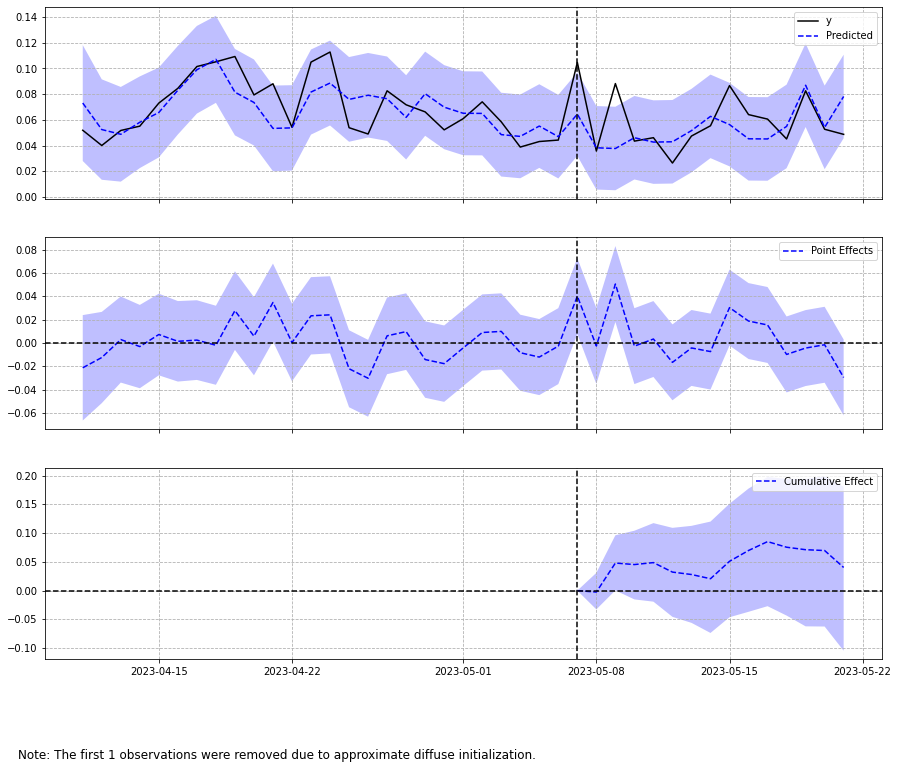

In [7]:
print('perc_products_pna, with a p_value of {}'.format(model1.p_value))
model1.plot()

UIPO, with a p_value of 0.2997002997002997


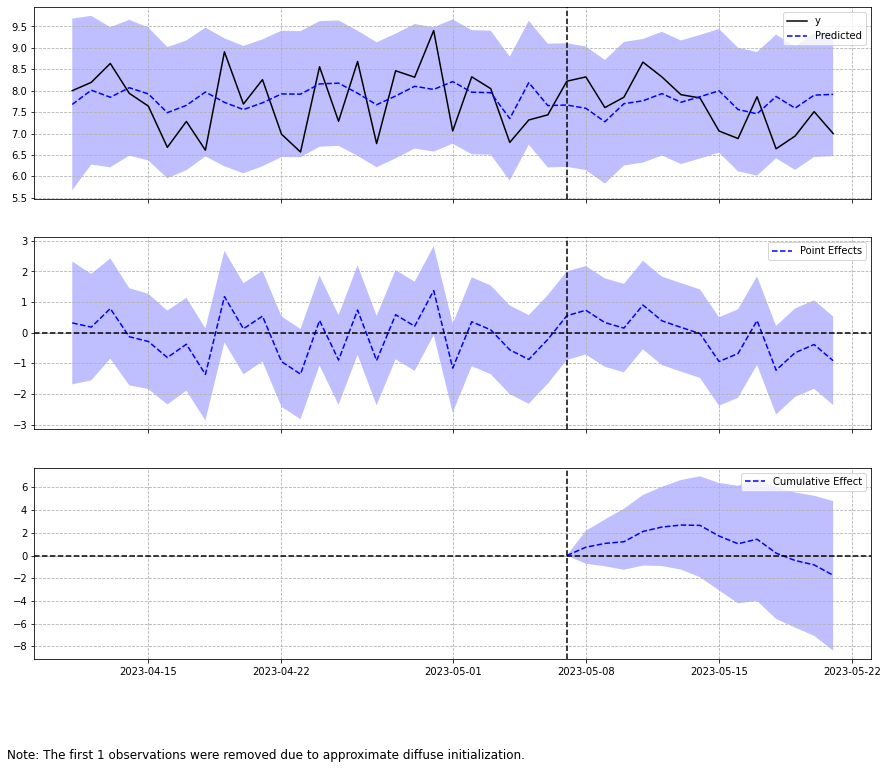

In [8]:
print('UIPO, with a p_value of {}'.format(model2.p_value))
model2.plot()

number_of_placed_products 0.0899100899100899


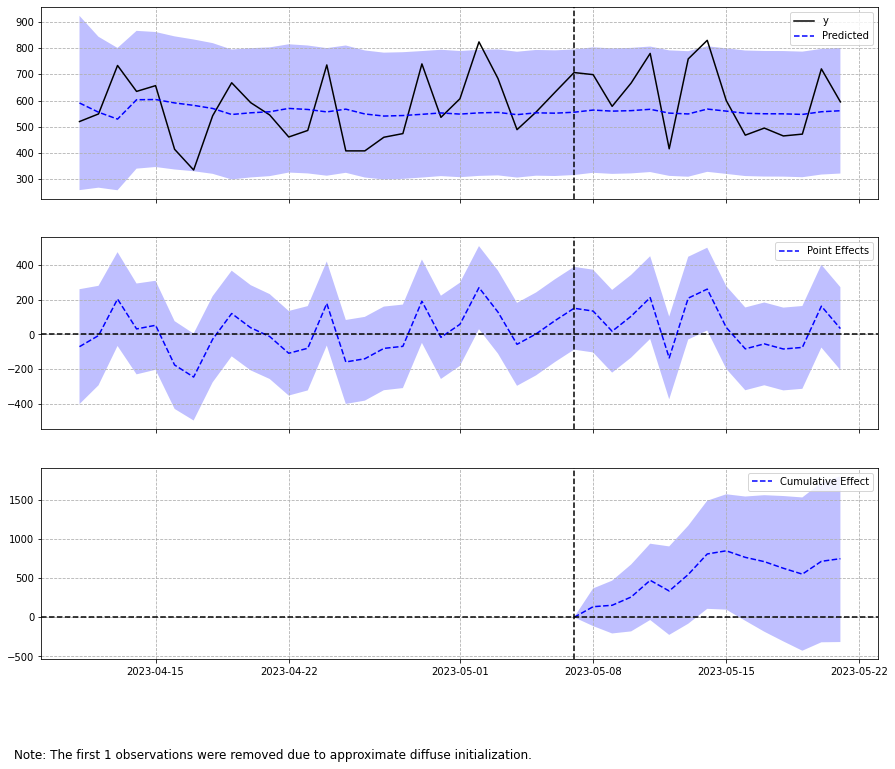

In [9]:
print('number_of_placed_products {}'.format(model3.p_value))
model3.plot()

###  Final check

In [10]:
# Be aware that the can be some small changes in the p values as everytime 
# that the model runs, it gets different values.
results_df.loc[[results_df['total_rank'].idxmin()]]

,Group,p_value_number_of_placed_products,p_value_perc_products_pna,p_value_UIPO,rank_p_value_number_of_placed_products,rank_p_value_perc_products_pna,rank_p_value_UIPO,total_rank
8,"{""columns"":[""store_address"",""Group""],""index"":[...",0.071928,0.292707,0.267732,2.0,2.0,2.0,6.0


In [11]:
rw.write_file(df_group_config, 'SPM_group_creator_CARR_GE.csv')